# Applying Hybrid Monte-Carlo (HMC) to the long range Ising model
A Hybrid Monte-Carlo algorithm is used to study the dynamics of a long range 2d spin lattice and compared with analytically obtained results. Also a leap-frog integration is implemented in the process of the HMC algorithm. Bootstrap methods are used for error analysis of computed observables. 

## Theory
The hamiltonian for the given Spin-System reads 
$$\mathcal{H}(s,h)=-\frac{1}{2}\hat{J}\sum_{i,j}s_is_j-h\sum_is_i,$$
where $i,j=0,\dots,N$. One can apply a Hubbard-Stratonovich transformation to obtain a continous partition function
$$Z[J>0]=\int_{-\infty}^\infty \frac{d\phi}{\sqrt{2\pi\beta\hat{J}}}e^{-\frac{\phi^2}{2\beta\hat{J}}+N\log(2\cosh(\beta h\pm\phi))}$$
*The expectation value of some operator $O$ is given by
$$\langle O \rangle = \frac{1}{Z}\int \frac{\text{d}\phi}{\sqrt{2\pi\beta\hat{J}}} O[\phi]e^{-S[\phi]}$$ Use the expression above and the fact that the mean magnetization (per site) and energy (per
site) are given by $$\langle m\rangle=\frac{T}{N}\frac{\partial\log Z}{\partial h },$$
$$\langle \varepsilon\rangle-\frac{1}{N}\frac{\partial\log Z}{\partial \beta }$$
to derive corresponding expressions for $O[\phi]$ for these quantities.*

Doing the math yields:
$$m[\phi]=\tanh{(\beta h \pm \phi)}$$
$$\varepsilon[\phi]=-\frac{1}{N}\left(\frac{\phi^2}{2\beta^2\hat{J}}+h\cdot\tanh(\beta h \pm \phi) -\frac{1}{2\beta} \right)$$

Any obervable is then calculated as $$\langle O \rangle=\frac{1}{N_{cnfg}}\sum O[\phi]$$
We encounter the following artificial Hamiltonian in the process of the HMC algorithm:

$$\mathcal{H}^{art}=\frac{p^2}{2}+\frac{\phi^2}{2\beta \hat{J}}-N\log(2\cosh(\beta h + \phi) )$$

*Determine the equations of motion (EoMs) for this Hamiltonian by applying the
Hamilton equations*

$$\dot{p}=-\frac{\partial\mathcal{H}}{\partial\phi}=-\left(\frac{\phi}{\beta \hat{J}}-N\cdot\tanh(\beta h + \phi)\right)$$
$$\dot{\phi}=\frac{\partial\mathcal{H}}{\partial p}=p$$


## Aim of the Code
Now follows a brief explanation of the written Code.
### Numerical Approach
First the numerical approach...
#### Leap-Frog algorithm
*Code up the leapfrog algorithm to evolve $(p_0,\phi_0) \to (p_f , \phi_f )$. Verify the convergence claim $\mathcal{H}(p_f,\phi_f) = \mathcal{H}(p_0,\phi_0) + \mathcal{O}(\epsilon^2)$.*

The leap-frog algorithm integrates coupled differential equations leap-wise (hence the name). The coupled differential equation are the EoMs derivated above which leave the artificial Hamiltonian invariant. The convergence can be verified for (arbitrary) parameters $N=15,J=1,h=1$.

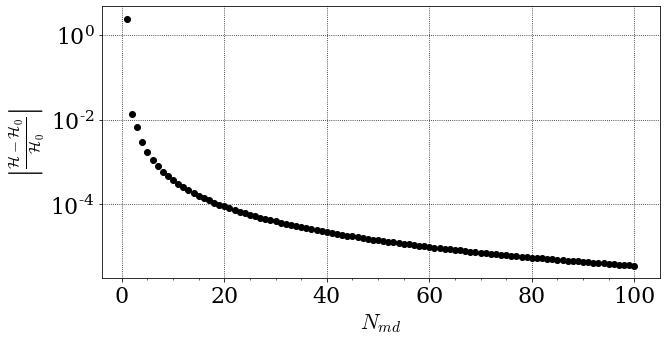

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sc

T=1
beta=1/T
N=15
J=1
h=1
#pretty plots
def beauty_plot():
    plt.figure(figsize=(10,5))
    plt.minorticks_on()
    plt.rcParams["mathtext.fontset"]="cm"
    plt.rcParams['errorbar.capsize'] = 3
    plt.rcParams['mathtext.rm'] = 'serif'
    font={'family' : 'serif','size'   : 22}
    plt.rc("font",**font)
    plt.xticks(fontsize=22,fontname='DejaVu Serif')
    plt.yticks(fontsize=22,fontname='DejaVu Serif')
    plt.grid(color='black',linestyle=':')

def leap_frog(N_md, p_0, phi_0, J):
    epsilon = 1/N_md
    p, phi = p_0, phi_0
    #first leap-frog step
    phi = phi+epsilon/2*p
    for i in range(0,N_md-1):
        p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
        phi=phi+epsilon*p
    #last step of leap-frog
    p=p-epsilon*(phi/(beta*J)-N*np.tanh(beta*h+phi))
    phi=phi+epsilon/2*p
    return p, phi
#artificial hamiltonian
def art_hamiltonian(p, phi,J, N):
    return p**2/2+phi**2/(2*beta*J)-N*np.log(2*np.cosh(beta*h+phi))

p_0=1
phi_0=1#arbitrary start values
hamiltonian_0=art_hamiltonian(p_0,phi_0,J/N ,N)
hamiltonian=[]
for i in range(1,101):
    p, phi = leap_frog(i,p_0,phi_0, J/N)
    hamiltonian.append(np.abs((art_hamiltonian(p,phi,J/N,N)-hamiltonian_0)/hamiltonian_0))
beauty_plot()
plt.plot(np.linspace(1,100,100),hamiltonian,'o',c="black")    
plt.yscale("log")    
plt.xlabel("$N_{md}$",fontsize=22)
plt.ylabel("$\\left|\\frac{\\mathcal{H}-\\mathcal{H}_0}{\\mathcal{H}_0}\\right|$",fontsize=22)
plt.show()

#### Implementing HMC 

The HMC algorithm now consists of promoting a global change in the continous spin-variable $\phi$ through integration of the EoMs of the artificial hamiltonian with a randomly generated $p$ from a normal distribution, followed by the well-known ACCEPT/REJECT step. It therefore consists of the following steps:
1. sample $p \in \mathcal{N_{0,1}}$
2. Integrate the EoMs using leapfrog to obtain a trial $(p',\phi')$ (starting with arbitrary $\phi$)
3. ACCEPT $\phi'$ with probability $$\min\{1,e^{-(\mathcal{H_0}-\mathcal{H}})\}$$
4. repeat

Smart people figured out that this generates the correct probability distribution
$d\phi P[\phi] \propto d\phi e^{-\frac{\phi^2}{2\beta\hat{J}}+N\log(2\cosh(\beta h+\phi))}$

In [2]:
nTrajs = 4000
N_md = 50
N = 15
h=.5
nBS=100 #number of bootstrap iterations
#calculate bootstrap error
def bootstrap_error(s, nBS): 
    n=len(s)
    bsmean = np.array([])
    for bs in range(nBS):
        index = np.random.randint(n, size=n)
        bsmean = np.append(bsmean, np.array([s[index[i]] for i in range(n)]).mean())
    return bsmean.std()



def numerical(J):
    phi_list = [1] # arbitrary start value
    m_observe = []
    energy_observe = []
    for traj in range(nTrajs):
        p_0 = np.random.normal(0,1) #sample randomly from normal dist.
        phi_0 = phi_list[-1] # each consecutive start value is phi from iteration before
        hamiltonian_0 = art_hamiltonian(p_0, phi_0, J/N, N) # calculate start hamilton
        # Calculate p' and phi'
        p, phi = leap_frog(N_md,p_0,phi_0, J/N)
        hamiltonian = art_hamiltonian(p, phi, J/N, N) # calculate end hamilton
        if np.random.uniform(0,1)<=np.exp(-beta*(hamiltonian-hamiltonian_0)):
            phi_list.append(phi) #accept
        else:
            phi_list.append(phi_0) #reject this is less than 50% for N_md=50
    # Measurements
    m = []
    e=[]
    for phi in phi_list:
        m.append(np.tanh(beta*h+phi)) # take measuremente like described above
        e.append(-1/N*(phi*phi/(2*beta*beta*J/N)+h*N*np.tanh(beta*h+phi)-1/(2*beta)))
    
    return np.mean(m), np.mean(e), bootstrap_error(m, nBS), bootstrap_error(e, nBS)


### Analytical approach
This was also figured out by smart people. The analytical solutions to the given problem are
$$Z=\sum_{n=0}^N\binom N n f(\beta \hat{J},\beta h, N-2n)$$
$$\langle \beta \varepsilon \rangle=-\frac{1}{NZ}\sum_{n=0}^N\binom N n \left[\frac{1}{2}\beta\hat{J}(N-2n)^2+\beta h(N-2n)\right]f(\beta\hat{J},\beta h, N-2n)$$
$$\langle m \rangle=\frac{1}{NZ}\sum_{n=0}^N\binom N n (N-2n)f(\beta\hat{J},\beta h, N-2n)$$
$$f(\beta\hat{J},\beta h,x):=e^{\frac{1}{2}\beta\hat{J}x^2+\beta hx}$$
and are implemented below in python code.

In [3]:
def f_func(x,J,N):
    return np.exp(1/2*beta*J/N*x**2+beta*h*x)

def Z_func(J, N):
    f_sum = 0
    N_list = np.linspace(0, N, N+1)
    for n in N_list:
        f_sum += sc.binom(N, n)*f_func(N-2*n,J, N)
    return f_sum

def m_analytical(J, N):
    m_sum = 0
    N_list = np.linspace(0, N, N+1)
    for n in N_list:
        m_sum += sc.binom(N, n)* f_func(N-2*n, J, N)*(N-2*n)
    return 1/(N*Z_func(J, N))*m_sum
def energy_analytical(J,N):
    e_sum=0
    N_list=np.linspace(0,N,N+1)
    for n in N_list:
        e_sum+=sc.binom(N,n)*(0.5*beta*J/N*(N-2*n)**2+beta*h*(N-2*n))*f_func(N-2*n,J,N)
    return -1/(N*Z_func(J, N))*e_sum
    

In [4]:
N_list = np.array([5,10, 15, 20]) 
J_list = np.array(np.linspace(0.2,2,15))


m_observed = []
m_error = []
energy_observed = []
energy_error = []
#create data lists for each J and N
count = 0
for N in N_list:
    m_observed.append([])
    m_error.append([])
    energy_observed.append([])
    energy_error.append([])
    for J in J_list:
        m, e, error_m, error_e = numerical(J)
        m_observed[count].append(m)
        energy_observed[count].append(e)
        m_error[count].append(error_m)
        energy_error[count].append(error_e)
    count += 1


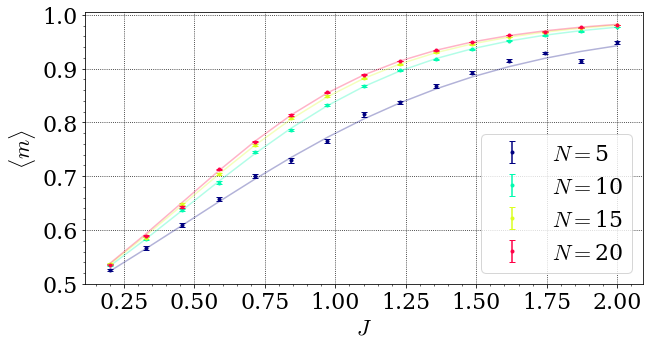

In [5]:
#plot numerical results vs. analytical results
beauty_plot()
colormap = plt.cm.gist_ncar
colors = [colormap(i) for i in np.linspace(0, 1,len(N_list)+1)]
for i in range(len(m_observed)):
    plt.errorbar(x=J_list, y=m_observed[i],yerr=m_error[i],marker='.',color=colors[i],linestyle="None", label = "$N=$%d"%(N_list[i]))
    plt.plot(J_list, m_analytical(J_list, N_list[i]), color=colors[i],alpha=0.3)
plt.xlabel("$J$")
plt.ylabel("$\\langle m \\rangle$")
plt.legend()
plt.show()


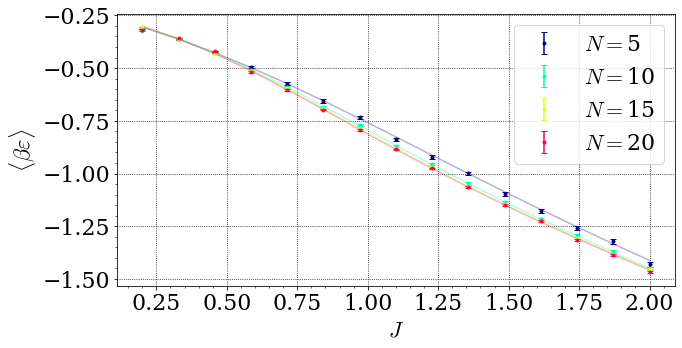

In [6]:
#plot numerical results vs. analytical results
beauty_plot()
for i in range(len(energy_observed)):
    plt.errorbar(x=J_list, y=energy_observed[i],yerr=energy_error[i],color=colors[i],marker='.',linestyle="None", label = "$N=$%d"%(N_list[i]))
    plt.plot(J_list, energy_analytical(J_list, N_list[i]),color=colors[i],alpha=0.3)
plt.xlabel("$J$")
plt.ylabel("$\\langle \\beta\\varepsilon \\rangle$")
plt.legend()
plt.show()


Our simulations fit the analytically obtained data well, although one can see, that the simulated data fits better to the analytical for larger N. The estimated bootstrap error is very small. 